### Please refer to the presentation slide below for project details 
https://docs.google.com/presentation/d/1CZB_9_-Djarj7apGhPhtGLHQZG8wuWjIAzIACbr81ac/edit?usp=sharing



### Remark: Note that the dataset is not imported here due to data privacy and only demonstrates the code of what we've done.

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

from pylab import rcParams
import math

import matplotlib.pyplot as plt
import matplotlib


from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
import xgboost as xgb


In [ ]:
df = pd.read_csv('imputed2017_18_label_inc_night.csv')

In [ ]:
df['DATETIME'] = df['DATETIME'].astype('datetime64')
df = df.set_index('DATETIME').between_time('03:00', '18:00', include_start = True,include_end = True)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define plotting functions

In [ ]:
plt.style.use('seaborn-darkgrid')

def visualize(df, model_col , measure_col ,capacity =1000 , style = 'bar',show = False, save = False, visualize = True):
    ''' 
    usage : this object use to analysis statistical charasteristic of prediction value
    requirement : for DataFrame in format2 (must include 'Datetime' column !) 
                and shouldn't be more than 6 models (color issue for visualization)
    ''' 
    df['time'] = [t.time() for  t in df['Datetime']]
    error_matrix ={}
    rmse_matrix = {}
    mbe_matrix = {}
    for i in model_col:
        df[f'error_{i}'] = df[i]-df[measure_col]
        mbe = df[f'error_{i}'].dropna().values.mean()
        mae = (np.abs(df[f'error_{i}'].dropna().values)).mean()
        rmse = np.sqrt((df[f'error_{i}'].dropna().values**2).mean())
        nrmse = (rmse/capacity)*100
        error_matrix[i] = [mbe, mae, rmse, nrmse]
        groups = df.groupby('time')[f'error_{i}']
        rmse_groups = groups.apply(lambda x : np.sqrt((x.dropna().values**2).mean()))
        mbe_groups = groups.apply(lambda x: x.dropna().values.mean())
        time = rmse_groups.index.values
        rmse_matrix[i] = rmse_groups.values
        mbe_matrix[i] = mbe_groups.values
    error_df = pd.DataFrame(error_matrix, index = ['MBE','MAE','RMSE','NRMSE'])
    rmse_df = pd.DataFrame(rmse_matrix, index = time)
    mbe_df = pd.DataFrame(mbe_matrix, index = time)
    print('error summary')
    print('')
    print(error_df)
    if show :
        print('-------------------------')
        print('')
        print('RMSE each timepoint')
        print(rmse_df)
        print('-------------------------')
        print('')
        print('MBE each timepoint')
        print(mbe_df)
        
    # visualize RMSE
    if visualize:
        rcParams['figure.figsize'] = 15,12
        fig, axes  = plt.subplots(2,1)
        model = rmse_df.columns.to_list()
        barwidth = 0.2
        n_model = rmse_df.shape[1]
        n_timestep = rmse_df.shape[0]
        r0 = np.arange(n_timestep)
        colors = ['indianred','goldenrod', 'yellowgreen','olivedrab','lightskyblue','royalblue'] 
        if style == 'bar':
            for i in range(n_model):
                r = [x + i*barwidth for x in r0]
                axes[0].bar(r, rmse_df.iloc[:,i],width = barwidth, label = model[i], color = colors[i])
            axes[0].set_xticks([R + (n_model//2-1)*barwidth for R in range(n_timestep)])
            axes[0].set_xticklabels([t[:-3] for t in time.astype('str')])
        elif style == 'line':
            for i in range(n_model):             
                axes[0].plot([t[:-3] for t in time.astype('str')], rmse_df.iloc[:,i].values,'o-', color = colors[i] , label = model[i])
        else:
            raise 'Error: invalid style'


        axes[0].set_xlabel('time of forecasts', fontsize = 13)
        axes[0].set_ylabel('RMSE of solar irradiance(W/m^2)', fontsize = 13)
        axes[0].legend()
        print('')

        #visualize MBE
        for i in range(n_model):
            r = [x + i*barwidth for x in r0]
            axes[1].bar(r, mbe_df.iloc[:,i],width = barwidth, label = model[i], color = colors[i])
        axes[1].set_xticks([R + (n_model//2-1)*barwidth for R in range(n_timestep)])
        axes[1].set_xticklabels([t[:-3] for t in time.astype('str')])
        axes[1].set_xlabel('time of forecasts', fontsize = 13)
        axes[1].set_ylabel('MBE of solar irradiance(W/m^2)', fontsize = 13)
        axes[1].legend()
        if save :
            name = str(input('Enter figure name: '))
            fig.savefig(f'{name}.png')



In [ ]:
def plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,model_name):
    batches = ['Batch1','Batch2','Batch3','Batch4','Batch5','Batch6']
    batch_error = pd.DataFrame({'batch':batches,'rmse_train':train_rmse_list,'rmse_validation':validation_rmse_list,'rmse_test':test_rmse_list})
    batch_error
    
    batch_train_size = 0
    for batch in batch_train_list:
        batch_train_size += len(batch)
    
    batch_validation_size = 0
    for batch in batch_validation_list:
        batch_validation_size += len(batch)

    N = 6
    ind = np.arange(N)
    width = 0.3
    colors = ['indianred','goldenrod', 'yellowgreen','olivedrab','lightskyblue','royalblue'] 
    plt.figure(figsize = (15,12))
    plt.bar(ind,batch_error['rmse_train'],width,label='RMSE_train',color = colors[0],alpha = 0.85)
    plt.bar(ind+width,batch_error['rmse_validation'],width,label='RMSE_Validation',color = colors[1],alpha = 0.85)
    plt.bar(ind+(2*width),batch_error['rmse_test'],width,label='RMSE_Test',color = colors[2],alpha = 0.85)
    plt.xticks(ind + width / 2, ('Dec-Jan', 'Feb-Mar', 'Apr-May', 'Jun-Jul', 'Aug-Sept', 'Oct-Nov'),fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(str('RMSE for '+ model_name),fontsize=25)
    plt.xlabel('Batch',fontsize=20)
    plt.ylabel('RMSE',fontsize=20)
    plt.legend(prop={"size":15})
    plt.show()
    return batch_error

# Feature Engineering

#### One of the potential estimator of solar irradiance is clear sky irradiance, which is the solar irradiance under cloudless sky. The clear sky irradiance can be derived from multiple physics equation. For our project we use Adnote-Bourges-Campana-Gicquel's equation to calculate clear sky irradiance which will be further used in our model.

#### Reference: https://prod-ng.sandia.gov/techlib-noauth/access-control.cgi/2012/122389.pdf

In [ ]:
def clearsky_cal(sza):
    if sza > 0:
        return 951.39*(sza**(1.15))
    else:
        return 0

In [ ]:
df['Iclr(t+6)'] = df['sza(t+6)'].apply(clearsky_cal)
df['Iclr(t)'] = df['sza'].apply(clearsky_cal)

### Compare Measured Irradiance vs Clear sky Irradiance

In [ ]:
show_date = '2017-03-03'
df_show_raw = df[df['date'] == show_date]
df_show_raw = df_show_raw.between_time('6:00','18:00').reset_index()
time_raw = df_show_raw['DATETIME']
Ir_raw = df_show_raw['I']

In [ ]:
df_show_clr = df[df['date'] == show_date]
df_show_clr = df_show_clr.between_time('6:00','18:00').reset_index()
time_clr = df_show_clr['DATETIME']
Ir_clr = df_show_clr['Iclr(t)']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


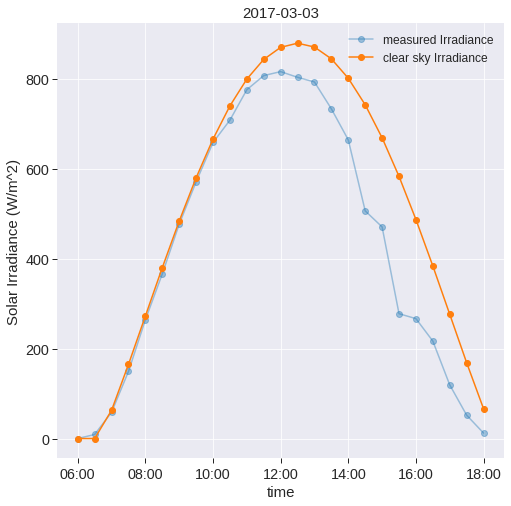

In [ ]:
rcParams['figure.figsize'] = 8, 8
fig, ax1 = plt.subplots()
ax1.set_xlabel('time', fontsize = 15)
ax1.set_ylabel('Solar Irradiance (W/m^2)', fontsize = 15)
ax1.plot(time_raw,Ir_raw,'o-', alpha = 0.4, label='Measured Irradiance',color = 'tab:blue')
ax1.plot(time_clr,Ir_clr,'o-', alpha = 1, label='clear sky Irradiance',color = 'tab:orange')
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax1.legend(loc = 1, fontsize = 'large')
ax1.tick_params(length =5, width = 1,labelsize = 'x-large')
ax1.set_title(f'{show_date}', fontsize = 15)
ax1.legend(loc = 1, fontsize = 'large')
plt.savefig('ex_clear_sky.eps',format = 'eps')

### Compare EMA Irradiance vs Measured Irradiance

In [ ]:
df['Iema^(d-1)(t+6)'] = df.groupby('time')['I^(d-1)(t+6)'].transform(lambda x : x.ewm(alpha=0.8, ignore_na = False).mean())

In [ ]:
show_date = '2017-03-03'
df_show_raw = df[df['date'] == show_date]
df_show_raw = df_show_raw.between_time('6:00','18:00').reset_index()
time_raw = df_show_raw['DATETIME']
Ir_raw = df_show_raw['I']

In [ ]:
df_show_ema = df[df['date'] == show_date]
df_show_ema = df_show_ema.between_time('3:00','15:00').reset_index()
Ir_ema = df_show_ema['Iema^(d-1)(t+6)']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


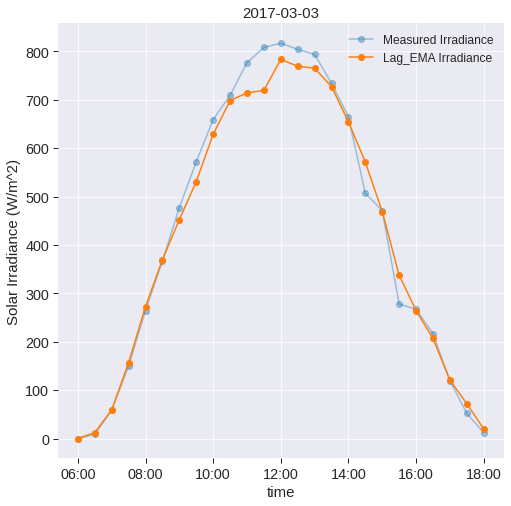

In [ ]:
rcParams['figure.figsize'] = 8,8
fig, ax1 = plt.subplots()
ax1.set_xlabel('time', fontsize = 15)
ax1.set_ylabel('Solar Irradiance (W/m^2)', fontsize = 15)
ax1.plot(time_raw,Ir_raw,'o-', alpha = 0.4, label='Measured Irradiance',color = 'tab:blue')
ax1.plot(time_raw,Ir_ema,'o-', alpha = 1, label='Lag_EMA Irradiance',color = 'tab:orange')
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
ax1.legend(loc = 1, fontsize = 'large')
ax1.tick_params(length =5, width = 1,labelsize = 'x-large')
ax1.set_title(f'{show_date}', fontsize = 15)
ax1.legend(loc = 1, fontsize = 'large')
plt.savefig('ex_lag_ema.eps',format = 'eps')



# Create Training & Validation Set

#### The picture below shows how the train, validation, test data are split.

![](https://drive.google.com/uc?id=1KvxjXslBN6DGVnjZtanva75MmKBqK5yd)


In [ ]:
feature_cols = ['I','RH', 'UV', 'WS', 'sza', 'I^(d-1)(t+6)',
       'I(t-1)', 'I(t-2)', 'I(t-3)', 'I(t-4)', 'I(t-5)', 'I(t-6)', 'I(t-7)', 'sza(t+6)']
target = ['I(t+6)']

In [ ]:
def data_preparation(df,is_train = False):
  if is_train == True:
    ## Create Lag Irradiance feature for train dataset
    df['I^(d-1)(t+6)'] = df['I'].shift(23,axis = 0)
    df.dropna(inplace = True)
  else:
    df.dropna(subset = feature_cols + target,inplace = True)


  ## Note that the predictons start at 4:00 and ends at 15:00
  df = df.between_time('04:00', '15:00', include_start = True,include_end = True)

  return df

### Create training set

In [ ]:

batch1_a_train = df.loc['2017-01-01':'2017-01-31']
batch1_b_train = df.loc['2017-12-01':'2017-12-31']
batch1_train = pd.concat([batch1_a_train,batch1_b_train])

batch2_train = df.loc['2017-02-01':'2017-03-31']
batch3_train = df.loc['2017-04-01':'2017-05-31']
batch4_train = df.loc['2017-06-01':'2017-07-31']
batch5_train = df.loc['2017-08-01':'2017-09-30']
batch6_train = df.loc['2017-10-01':'2017-11-30']


batch1_train = data_preparation(batch1_train,is_train = True)
batch2_train = data_preparation(batch2_train,is_train = True)
batch3_train = data_preparation(batch3_train,is_train = True)
batch4_train = data_preparation(batch4_train,is_train = True)
batch5_train = data_preparation(batch5_train,is_train = True)
batch6_train = data_preparation(batch6_train,is_train = True)


### Create validation set

In [ ]:
batch_validation1 = df.loc['2018-01-01':'2018-01-15']
batch_validation2 = df.loc['2018-02-01':'2018-02-15']
batch_validation3 = df.loc['2018-03-01':'2018-03-15']
batch_validation4 = df.loc['2018-04-01':'2018-04-15']
batch_validation5 = df.loc['2018-05-01':'2018-05-15']
batch_validation6 = df.loc['2018-06-01':'2018-06-15']
batch_validation7 = df.loc['2018-07-01':'2018-07-15']
batch_validation8 = df.loc['2018-08-01':'2018-08-15']
batch_validation9 = df.loc['2018-09-01':'2018-09-15']
batch_validation10 = df.loc['2018-10-01':'2018-10-15']
batch_validation11 = df.loc['2018-11-01':'2018-11-15']
batch_validation12 = df.loc['2018-12-01':'2018-12-15']


batch1_validation = pd.concat([batch_validation12,batch_validation1])
batch2_validation = pd.concat([batch_validation2,batch_validation3])
batch3_validation = pd.concat([batch_validation4,batch_validation5])
batch4_validation = pd.concat([batch_validation6,batch_validation7])
batch5_validation = pd.concat([batch_validation8,batch_validation9])
batch6_validation = pd.concat([batch_validation10,batch_validation11])

batch1_validation = data_preparation(batch1_validation)
batch2_validation = data_preparation(batch2_validation)
batch3_validation = data_preparation(batch3_validation)
batch4_validation = data_preparation(batch4_validation)
batch5_validation = data_preparation(batch5_validation)
batch6_validation = data_preparation(batch6_validation)


### Create Test set


In [ ]:
batch_test1 = df.loc['2018-01-16':'2018-01-31']
batch_test2 = df.loc['2018-02-16':'2018-02-28']
batch_test3 = df.loc['2018-03-16':'2018-03-31']
batch_test4 = df.loc['2018-04-16':'2018-04-30']
batch_test5 = df.loc['2018-05-16':'2018-05-31']
batch_test6 = df.loc['2018-06-16':'2018-06-30']
batch_test7 = df.loc['2018-07-16':'2018-07-31']
batch_test8 = df.loc['2018-08-16':'2018-08-31']
batch_test9 = df.loc['2018-09-16':'2018-09-30']
batch_test10 = df.loc['2018-10-16':'2018-10-31']
batch_test11 = df.loc['2018-11-16':'2018-11-30']
batch_test12 = df.loc['2018-12-16':'2018-12-31']

batch1_test = pd.concat([batch_test12,batch_test1])
batch2_test = pd.concat([batch_test2,batch_test3])
batch3_test = pd.concat([batch_test4,batch_test5])
batch4_test = pd.concat([batch_test6,batch_test7])
batch5_test = pd.concat([batch_test8,batch_test9])
batch6_test = pd.concat([batch_test10,batch_test11])


batch1_test = data_preparation(batch1_test)
batch2_test = data_preparation(batch2_test)
batch3_test = data_preparation(batch3_test)
batch4_test = data_preparation(batch4_test)
batch5_test = data_preparation(batch5_test)
batch6_test = data_preparation(batch6_test)

In [ ]:
print('missing value in test set')
pd.concat([batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]).isna().sum()

missing value in test set


I                    0
P                    5
T                  345
RH                   0
UV                   0
WS                   0
sza                  0
date                 0
time                 0
I^(d-1)(t+6)         0
I(t-1)               0
I(t-2)               0
I(t-3)               0
I(t-4)               0
I(t-5)               0
I(t-6)               0
I(t-7)               0
I(t-8)               0
sza(t+6)             0
I(t+6)               0
Iclr(t+6)            0
Iclr(t)              0
Iema^(d-1)(t+6)      0
dtype: int64

# Modeling

In [ ]:
feature_cols = ['I','RH','UV', 'WS', 'sza', 'I^(d-1)(t+6)','I(t-1)', 'I(t-2)',
                'I(t-3)', 'I(t-4)', 'I(t-5)', 'I(t-6)', 'I(t-7)','sza(t+6)']
target = ['I(t+6)']

### Baseline Model 

In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []

for idx,(batch_train,batch_val,batch_test) in enumerate(zip(batch_train_list,batch_validation_list,batch_test_list)):
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    yhat_train = batch_train['I^(d-1)(t+6)'].values
    yhat_val = batch_val['I^(d-1)(t+6)'].values
    yhat_test = batch_test['I^(d-1)(t+6)'].values
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{idx+1}_train : rmse = {rmse_train}')
    print(f'batch{idx+1}_validation : rmse = {rmse_val}')
    print(f'batch{idx+1}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 187.0618332054692
batch1_validation : rmse = 147.89111118867558
batch1_test : rmse = 124.89923160124114

batch2_train : rmse = 197.71286829902317
batch2_validation : rmse = 152.25305501727172
batch2_test : rmse = 173.7687032652392

batch3_train : rmse = 267.44190998721035
batch3_validation : rmse = 248.77022453358992
batch3_test : rmse = 267.3004953420367

batch4_train : rmse = 224.26943071215408
batch4_validation : rmse = 193.31841479299757
batch4_test : rmse = 231.40888023244653

batch5_train : rmse = 261.09239654766407
batch5_validation : rmse = 240.96417381627683
batch5_test : rmse = 207.89755282417147

batch6_train : rmse = 231.63123600523144
batch6_validation : rmse = 169.80343342445133
batch6_test : rmse = 166.02127227494066

average rmse of every batch in train = 230.19154475770148
average rmse of every batch in validation = 189.5559781175617
average rmse of every batch in test = 199.44036543576843


In [ ]:
baseline = pd.DataFrame()
baseline['measure'] = ybar_test
baseline['baseline'] = yhatbar_test
baseline['Datetime'] = date_test 

error summary

         baseline
MBE      1.436518
MAE    130.784049
RMSE   199.440365
NRMSE   19.944037



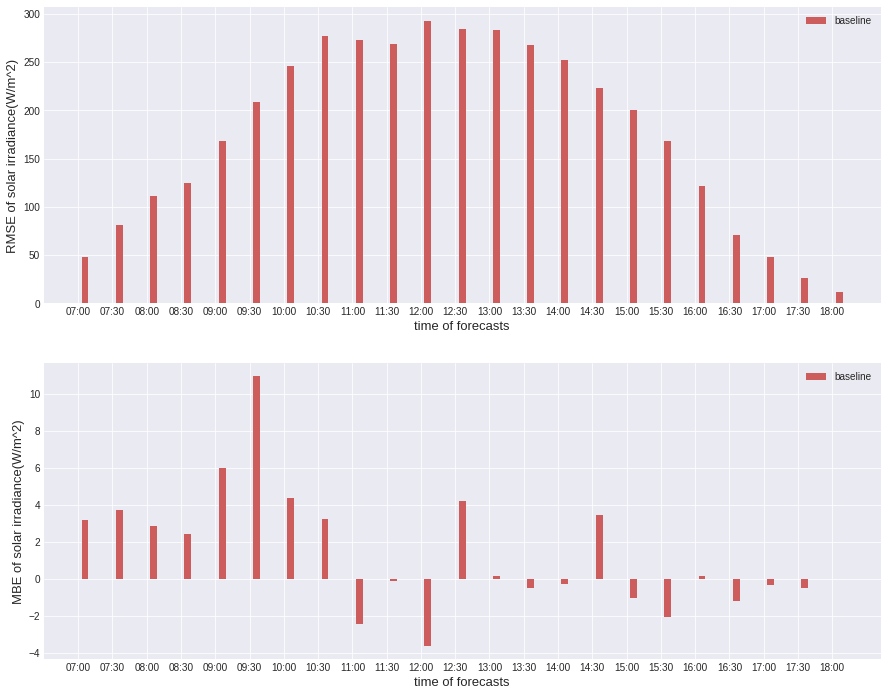

In [ ]:
visualize(baseline, ['baseline'] , 'measure' ,show = False, save = False, visualize = True)

# Regression

### Linear regression

In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0

train_rmse_list = []
test_rmse_list = []
validation_rmse_list = []

feature_cols = ['I','RH','UV', 'sza', 'I^(d-1)(t+6)', 'I(t-4)', 'I(t-7)','sza(t+6)']

for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############

    ############ MODEL #######################
    lin_reg = LinearRegression()
    lin_reg.fit(x_train,y_train)
    yhat_train = lin_reg.predict(x_train)
    yhat_val = lin_reg.predict(x_val)
    yhat_test = lin_reg.predict(x_test)
    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)

    yhat_train[yhat_train<0] = 0
    yhat_val[yhat_val<0] = 0
    yhat_test[yhat_test<0] = 0



    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    

    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    validation_rmse_list.append(rmse_val)
    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 119.70206455295103
batch1_validation : rmse = 121.93526328603492
batch1_test : rmse = 117.55347645570761

batch2_train : rmse = 112.93486352802081
batch2_validation : rmse = 123.47604618213688
batch2_test : rmse = 148.77126601213888

batch3_train : rmse = 179.11800101555997
batch3_validation : rmse = 190.73841980732473
batch3_test : rmse = 209.1891111841886

batch4_train : rmse = 147.52263584699355
batch4_validation : rmse = 161.55962869702537
batch4_test : rmse = 174.10518877140547

batch5_train : rmse = 170.98119300862925
batch5_validation : rmse = 167.62545734850494
batch5_test : rmse = 155.7208648534081

batch6_train : rmse = 155.64710116236452
batch6_validation : rmse = 147.03224147306776
batch6_test : rmse = 134.6865471036074

average rmse of every batch in train = 148.8129073731802
average rmse of every batch in validation = 150.7098889102028
average rmse of every batch in test = 158.51148747902104


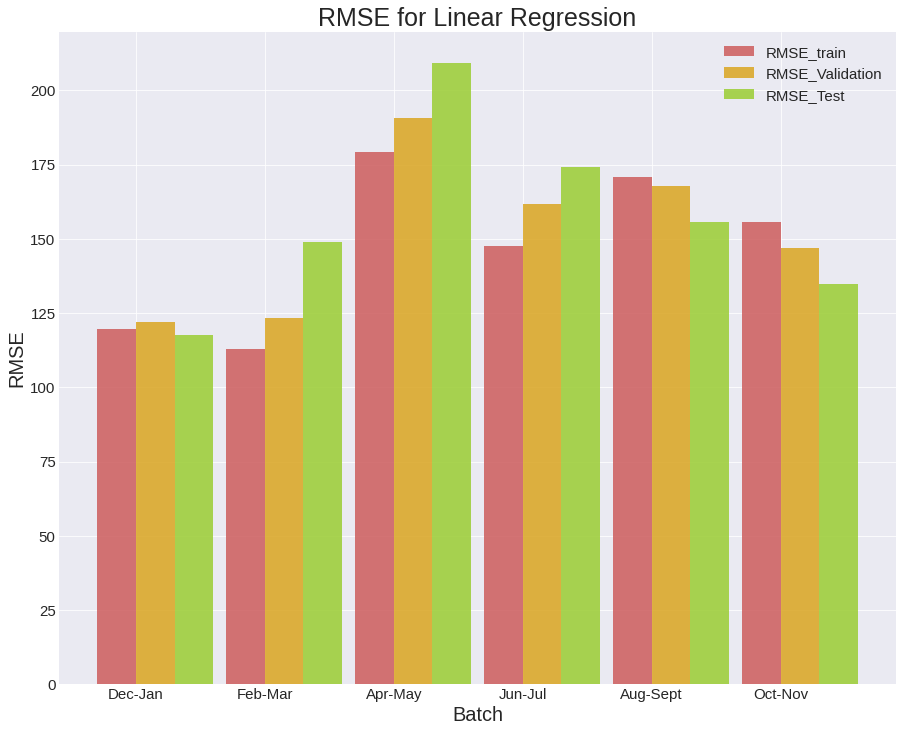

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,119.702065,121.935263,117.553476
1,Batch2,112.934864,123.476046,148.771266
2,Batch3,179.118001,190.738420,209.189111
3,Batch4,147.522636,161.559629,174.105189
4,Batch5,170.981193,167.625457,155.720865
5,Batch6,155.647101,147.032241,134.686547


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'Linear Regression')

### Ridge


In [ ]:
##Finding the best alpha for ridge
rmse_list = []
rmse_list_train =[]
dropped_features_list = []
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
r_2_list = []
log_alphas = np.flip(np.arange(-4,4.51,(4-(-4.5))/150))
alphas = math.e**log_alphas
feature_cols = ['I','RH','UV', 'sza', 'I^(d-1)(t+6)', 'I(t-4)', 'I(t-7)','sza(t+6)']
for alpha in alphas:
  r_2_alpha = 0
  pred_list = np.empty(0)
  y_true_list = np.empty(0)
  pred_list_train = np.empty(0)
  y_true_list_train = np.empty(0)
 
  for i in range(len(batch_train_list)):
    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]

    scaler = StandardScaler()
    batch_X_train = scaler.fit_transform(batch_X_train)
    batch_X_validation = scaler.transform(batch_X_validation)

    ridge = Ridge(alpha = alpha)
    ridge.fit(batch_X_train,batch_y_train)
    y_pred_batch_ridge = ridge.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_ridge)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])
    pred_list[pred_list<0] = 0
    y_pred_batch_ridge_train = ridge.predict(batch_X_train)

    pred_list_train = np.append(pred_list_train,y_pred_batch_ridge_train)
    y_true_list_train =  np.append(y_true_list_train,batch_y_train.values.reshape(1,-1)[0])

  rmse = np.sqrt(mean_squared_error(y_true_list,pred_list))
  rmse_list.append(rmse)
  
  rmse_train = np.sqrt(mean_squared_error(y_true_list_train,pred_list_train))
  rmse_list_train.append(rmse_train)

In [ ]:
result_ridge = pd.DataFrame({"alphas":alphas,"rmse_validation":rmse_list,'rmse_train':rmse_list_train})
result_ridge.sort_values(by='rmse_validation', ascending = True).head(10)     

,alphas,rmse_validation,rmse_train
42,8.331137,150.667558,149.820050
41,8.816868,150.667616,149.824882
43,7.872167,150.667699,149.815658
40,9.330917,150.667899,149.830193
44,7.438481,150.668015,149.811669
39,9.874938,150.668436,149.836026
45,7.028688,150.668485,149.808049
46,6.641470,150.669087,149.804766
38,10.450676,150.669257,149.842426
47,6.275585,150.669796,149.801792


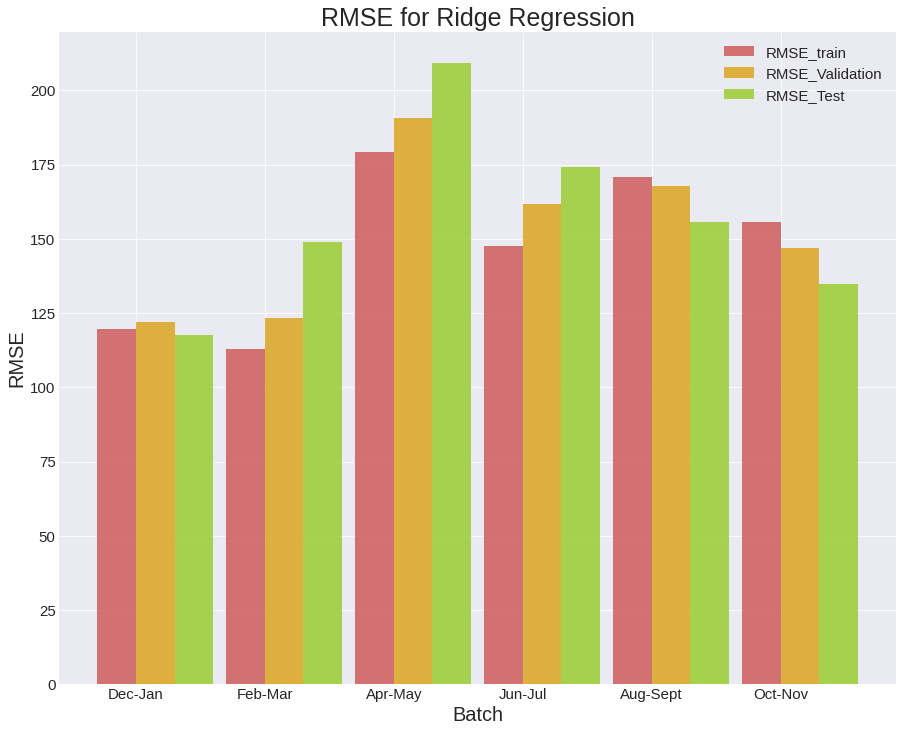

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,119.702065,121.935263,117.553476
1,Batch2,112.934864,123.476046,148.771266
2,Batch3,179.118001,190.738420,209.189111
3,Batch4,147.522636,161.559629,174.105189
4,Batch5,170.981193,167.625457,155.720865
5,Batch6,155.647101,147.032241,134.686547


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'Ridge Regression')

In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0
for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############

    ############ MODEL #######################
    ridge = Ridge(alpha = 19.491920)
    ridge.fit(x_train,y_train)
    yhat_train = ridge.predict(x_train)
    yhat_val = ridge.predict(x_val)
    yhat_test = ridge.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 123.75717935681591
batch1_validation : rmse = 132.21535097781677
batch1_test : rmse = 124.9377069810856

batch2_train : rmse = 118.91599813243214
batch2_validation : rmse = 138.0984297195028
batch2_test : rmse = 160.0998516425557

batch3_train : rmse = 183.80052721450164
batch3_validation : rmse = 194.72291542747618
batch3_test : rmse = 211.46104059274415

batch4_train : rmse = 152.20401575260277
batch4_validation : rmse = 162.29022442863817
batch4_test : rmse = 181.4800956478989

batch5_train : rmse = 176.4101056886668
batch5_validation : rmse = 169.53600239065003
batch5_test : rmse = 157.63498762880937

batch6_train : rmse = 159.139194394366
batch6_validation : rmse = 148.81566116402624
batch6_test : rmse = 139.73802761555177

average rmse of every batch in train = 154.4079363152893
average rmse of every batch in validation = 157.32557979017665
average rmse of every batch in test = 164.90794731459502


error summary

            ridge
MBE     21.682465
MAE    125.672196
RMSE   164.907947
NRMSE   16.490795



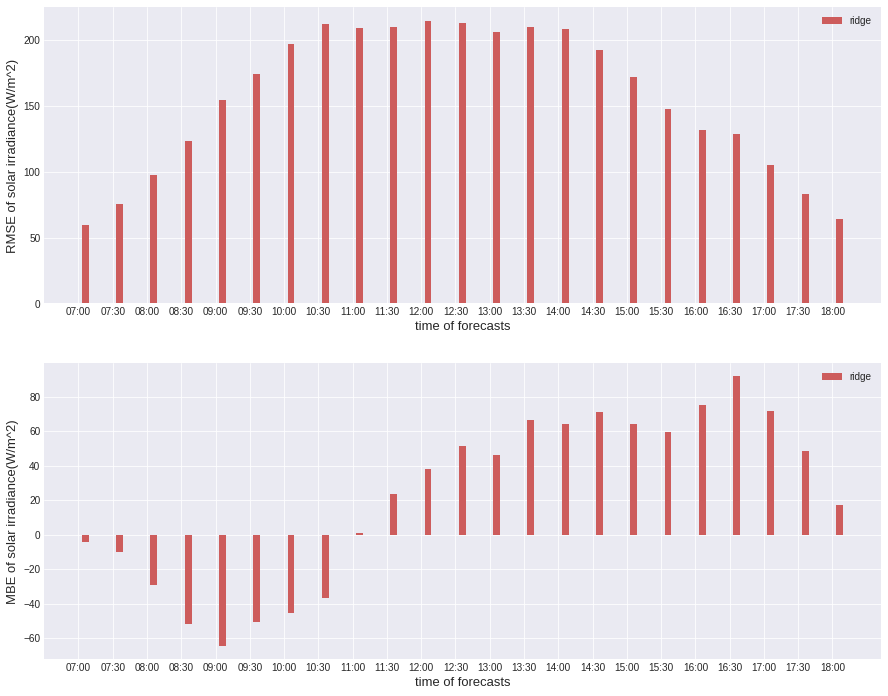

In [ ]:
ridge = pd.DataFrame()
ridge['measure'] = ybar_test
ridge['ridge'] = yhatbar_test
ridge['Datetime'] = date_test 
visualize(ridge, ['ridge'] , 'measure' ,show = False, save = False, visualize = True)

### Lasso

In [ ]:
##Finding the best alpha for lasso

rmse_list = []
rmse_list_train = []
dropped_features_list = []
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
r_2_list = []
log_alphas = np.flip(np.arange(-4,4.51,(4-(-4.5))/150))
alphas = math.e**log_alphas
for alpha in alphas:
  r_2_alpha = 0
  pred_list = np.empty(0)
  y_true_list = np.empty(0)
  pred_list_train = np.empty(0)
  y_true_list_train = np.empty(0)
  
  for i in range(len(batch_train_list)):
    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]

    scaler = StandardScaler()
    batch_X_train = scaler.fit_transform(batch_X_train)
    batch_X_validation = scaler.transform(batch_X_validation)

    lasso = Lasso(alpha = alpha)
    lasso.fit(batch_X_train,batch_y_train)
    y_pred_batch_lasso = lasso.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_lasso)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])
    pred_list[pred_list<0] = 0
    y_pred_batch_lasso_train = lasso.predict(batch_X_train)

    pred_list_train = np.append(pred_list_train,y_pred_batch_lasso_train)
    y_true_list_train = np.append(y_true_list_train,batch_y_train.values.reshape(1,-1)[0])

    # weighted_batch_r2 = (r2_score(batch_y_validation.values.reshape(1,-1)[0], y_pred_batch_lasso)) * len(batch_X_train)/len(train_final)
    # r_2_alpha += weighted_batch_r2
  # r_2_list.append(r_2_alpha)

  rmse = np.sqrt(mean_squared_error(y_true_list,pred_list))
  rmse_list.append(rmse)

  rmse_train = np.sqrt(mean_squared_error(y_true_list_train,pred_list_train))
  rmse_list_train.append(rmse_train)

In [ ]:
result_lasso = pd.DataFrame({"alphas":alphas,"rmse_validation":rmse_list,'rmse_train':rmse_list_train})
result_lasso.sort_values(by='rmse_validation', ascending = True).head()     

,alphas,rmse_validation,rmse_train
83,0.816006,150.543476,149.904455
84,0.771052,150.544524,149.891104
82,0.863582,150.544623,149.919232
85,0.728574,150.546249,149.878547
81,0.913931,150.546534,149.935695


In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []

train_rmse_list = []
test_rmse_list = []
validation_rmse_list = []
n = 0
for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############

    ############ MODEL #######################
    lasso = Lasso(alpha = 0.913931)
    lasso.fit(x_train,y_train)
    yhat_train = lasso.predict(x_train)
    yhat_val = lasso.predict(x_val)
    yhat_test = lasso.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')

    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    validation_rmse_list.append(rmse_val)
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 120.45774623188447
batch1_validation : rmse = 125.41067969731601
batch1_test : rmse = 119.93231845033729

batch2_train : rmse = 113.5936845788889
batch2_validation : rmse = 127.56085406065701
batch2_test : rmse = 151.36747412998417

batch3_train : rmse = 179.4634523591493
batch3_validation : rmse = 190.90527005071988
batch3_test : rmse = 209.44471301331447

batch4_train : rmse = 147.97482152680098
batch4_validation : rmse = 161.900733566553
batch4_test : rmse = 176.3441908855124

batch5_train : rmse = 171.34915777788717
batch5_validation : rmse = 167.23090710802893
batch5_test : rmse = 155.42665267983767

batch6_train : rmse = 156.01117270896398
batch6_validation : rmse = 147.34665694430203
batch6_test : rmse = 135.82368707850134

average rmse of every batch in train = 150.2344876866243
average rmse of every batch in validation = 152.85154594108715
average rmse of every batch in test = 160.68741551674344


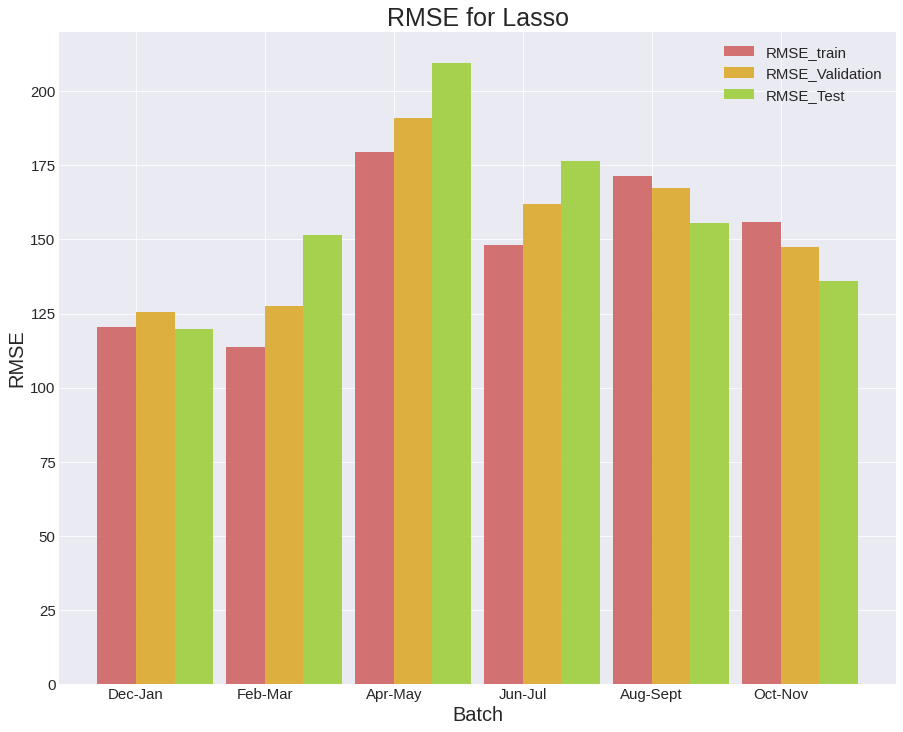

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,120.457746,125.410680,119.932318
1,Batch2,113.593685,127.560854,151.367474
2,Batch3,179.463452,190.905270,209.444713
3,Batch4,147.974822,161.900734,176.344191
4,Batch5,171.349158,167.230907,155.426653
5,Batch6,156.011173,147.346657,135.823687


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'Lasso')

error summary

            lasso
MBE     22.883221
MAE    121.060132
RMSE   160.687416
NRMSE   16.068742



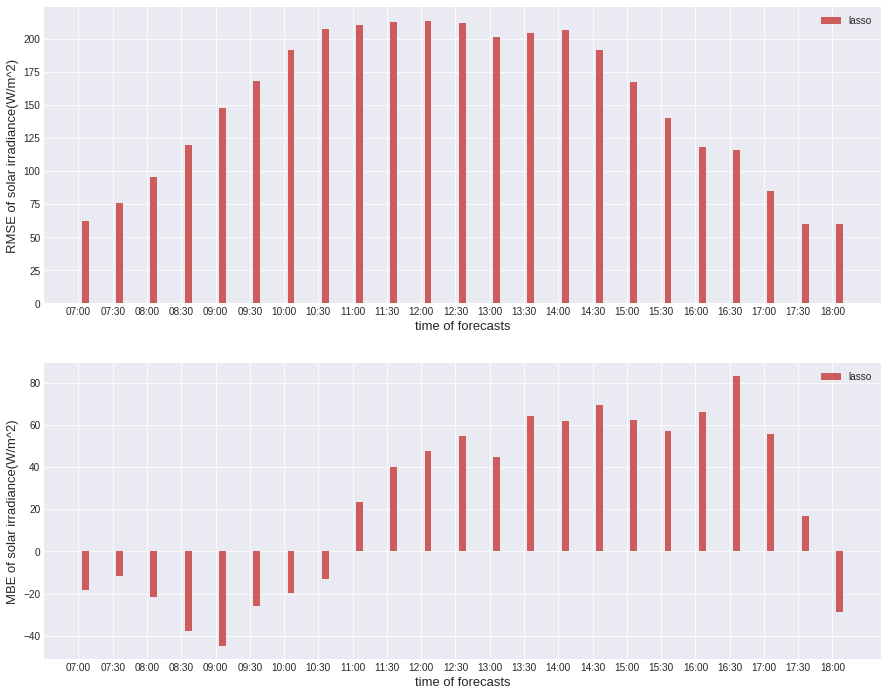

In [ ]:
lasso = pd.DataFrame()
lasso['measure'] = ybar_test
lasso['lasso'] = yhatbar_test
lasso['Datetime'] = date_test 
visualize(lasso, ['lasso'] , 'measure' ,show = False, save = False, visualize = True)

### Elastic

In [ ]:
result_elastic = pd.DataFrame({"Alpha":[],"L1_ratio":[],"rmse_validation":[],'rmse_train':[]})
result_elastic

,Alpha,L1_ratio,rmse_validation,rmse_train


In [ ]:
dropped_features_list = []
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
r_2_list = []
log_alphas = np.flip(np.arange(-4,4.51,(4-(-4.5))/150))
alphas = math.e**log_alphas
ratios = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
feature_cols = ['I','RH','UV', 'sza', 'I^(d-1)(t+6)', 'I(t-4)', 'I(t-7)','sza(t+6)']
for alpha in alphas:
  for ratio in ratios:
    r_2_alpha = 0
    pred_list = np.empty(0)
    y_true_list = np.empty(0)
    pred_list_train = np.empty(0)
    y_true_list_train = np.empty(0)
    for i in range(len(batch_train_list)):
      batch_X_train = batch_train_list[i][feature_cols]
      batch_y_train = batch_train_list[i][target]
      batch_X_validation =  batch_validation_list[i][feature_cols]
      batch_y_validation =  batch_validation_list[i][target]

      scaler = StandardScaler()
      batch_X_train = scaler.fit_transform(batch_X_train)
      batch_X_validation = scaler.transform(batch_X_validation)

      elastic = ElasticNet(alpha = alpha, l1_ratio=ratio,random_state=0) ## ration = 0.5(default)
      elastic.fit(batch_X_train,batch_y_train) 
      y_pred_batch_elastic = elastic.predict(batch_X_validation)

      pred_list = np.append(pred_list ,y_pred_batch_elastic)
      y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])
      pred_list[pred_list<0] = 0
      y_pred_batch_elastic_train = elastic.predict(batch_X_train)
      pred_list_train = np.append(pred_list_train,y_pred_batch_elastic_train)
      y_true_list_train = np.append(y_true_list_train,batch_y_train.values.reshape(1,-1)[0])


    result_elastic = result_elastic.append(pd.DataFrame({"Alpha":[alpha],"L1_ratio":[ratio],
                                                         "rmse_validation":[np.sqrt(mean_squared_error(y_true_list,pred_list))],
                                                         'rmse_train':[np.sqrt(mean_squared_error(y_true_list_train,pred_list_train))]}))

In [ ]:
result_elastic.sort_values(by='rmse_validation').head()

,Alpha,L1_ratio,rmse_validation,rmse_train
0,0.816006,1.0,150.543476,149.904455
0,0.771052,1.0,150.544524,149.891104
0,0.863582,1.0,150.544623,149.919232
0,0.728574,1.0,150.546249,149.878547
0,0.913931,1.0,150.546534,149.935695


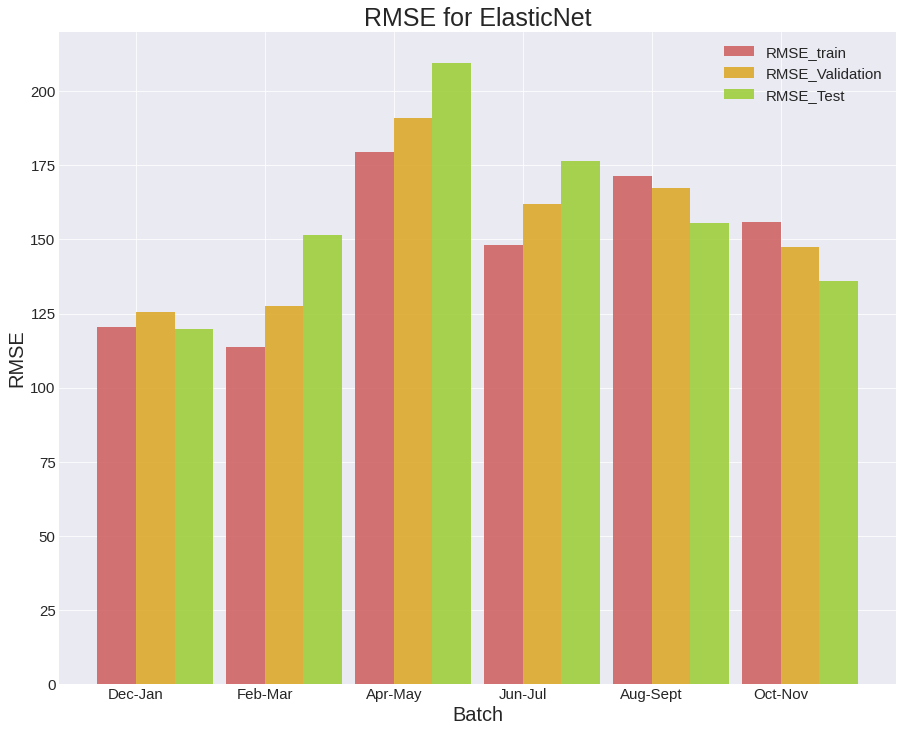

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,120.457746,125.410680,119.932318
1,Batch2,113.593685,127.560854,151.367474
2,Batch3,179.463452,190.905270,209.444713
3,Batch4,147.974822,161.900734,176.344191
4,Batch5,171.349158,167.230907,155.426653
5,Batch6,156.011173,147.346657,135.823687


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'ElasticNet')

In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0
for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############

    ############ MODEL #######################
    elastic = ElasticNet(alpha=1.146446,l1_ratio=1)
    elastic.fit(x_train,y_train)
    yhat_train = elastic.predict(x_train)
    yhat_val = elastic.predict(x_val)
    yhat_test = elastic.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 120.88897181929545
batch1_validation : rmse = 126.57676362896376
batch1_test : rmse = 120.77940095628682

batch2_train : rmse = 113.7185270243436
batch2_validation : rmse = 127.4872749696675
batch2_test : rmse = 151.50135420477153

batch3_train : rmse = 179.66129096148498
batch3_validation : rmse = 191.07705509096155
batch3_test : rmse = 209.66209881262955

batch4_train : rmse = 148.04409108845687
batch4_validation : rmse = 161.6014092893301
batch4_test : rmse = 176.29937730756475

batch5_train : rmse = 171.55984861335793
batch5_validation : rmse = 167.32410870839374
batch5_test : rmse = 155.50257109062673

batch6_train : rmse = 156.21960266643202
batch6_validation : rmse = 147.5429278294253
batch6_test : rmse = 136.205815245708

average rmse of every batch in train = 150.43572303539736
average rmse of every batch in validation = 153.0816842201692
average rmse of every batch in test = 160.94814602226464


error summary

          elastic
MBE     22.810187
MAE    121.344431
RMSE   160.948146
NRMSE   16.094815



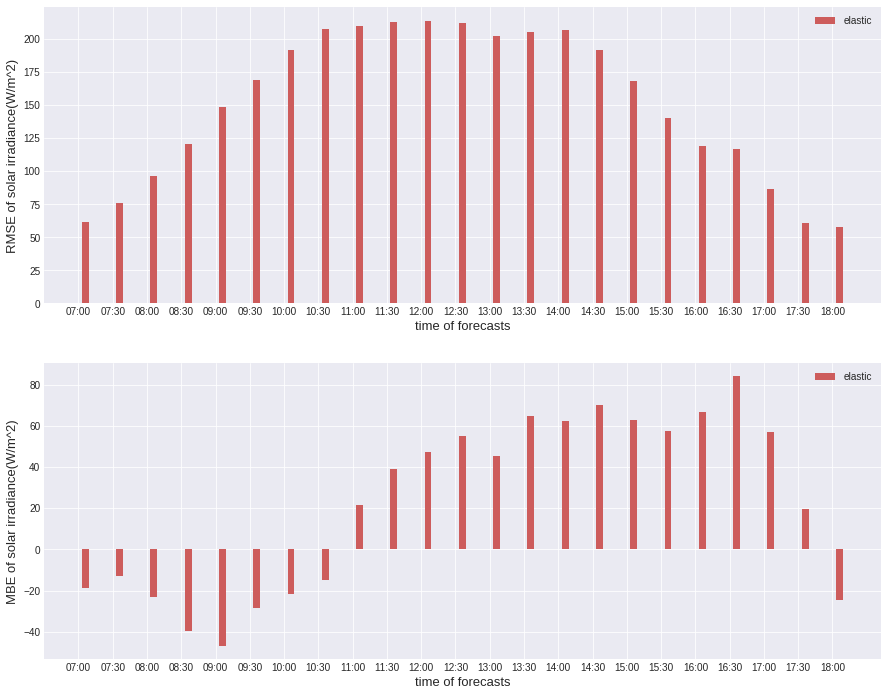

In [ ]:
elastic = pd.DataFrame()
elastic['measure'] = ybar_test
elastic['elastic'] = yhatbar_test
elastic['Datetime'] = date_test 
visualize(elastic, ['elastic'] , 'measure' ,show = False, save = False, visualize = True)

## Tree

### Decision tree

In [ ]:
result_dtree = pd.DataFrame({"Max depth":[],"Min_Sample_Splits":[],'Max_Features':[],"rmse_validation":[],'rmse_train':[]})
result_dtree

,Max depth,Min_Sample_Splits,Max_Features,rmse_validation,rmse_train


In [ ]:
rmse_list = []
dropped_features_list = []
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
r_2_list = []

max_depths = [2,3,4,5,6,7,11,15]
min_sample_splits = [3,5,7,9,11,13,15,20,25,30,35,40,50,75,100]
max_features = ['auto','sqrt','log2']

hyperparameters = []

for max_depth in max_depths:
  for min_sample_split in min_sample_splits:
    for max_feature in max_features:
      hyperparameters.append([max_depth,min_sample_split,max_feature])

for hyperparameter in hyperparameters:
  r_2_alpha = 0
  pred_list = np.empty(0)
  y_true_list = np.empty(0)
  pred_list_train = np.empty(0)
  y_true_list_train = np.empty(0)
  for i in range(len(batch_train_list)):
    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]

    dtree = DecisionTreeRegressor(max_depth=hyperparameter[0],min_samples_split = hyperparameter[1],max_features = hyperparameter[2],random_state=0)
    dtree.fit(batch_X_train,batch_y_train) 
    y_pred_batch_dtree = dtree.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_dtree)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])

    y_pred_batch_dtree_train = dtree.predict(batch_X_train)
    pred_list_train = np.append(pred_list_train,y_pred_batch_dtree_train)
    y_true_list_train = np.append(y_true_list_train,batch_y_train.values.reshape(1,-1)[0])
  rmse = np.sqrt(mean_squared_error(y_true_list,pred_list))
  rmse_list.append(rmse)

  rmse_train = np.sqrt(mean_squared_error(y_true_list_train,pred_list_train))

  result_dtree = result_dtree.append(pd.DataFrame({"Max depth":[hyperparameter[0]],"Min_Sample_Splits":[hyperparameter[1]],
                                                   'Max_Features':[hyperparameter[2]],"rmse_validation":[rmse],'rmse_train':[rmse_train],"R2": [r_2_alpha]}))

In [ ]:
result_dtree.sort_values(by='rmse_validation').head()

,Max depth,Min_Sample_Splits,Max_Features,rmse_validation,rmse_train,R2
0,5.0,35.0,log2,155.659412,141.996397,0.0
0,5.0,30.0,log2,155.685985,141.945668,0.0
0,6.0,100.0,log2,156.228206,143.414855,0.0
0,5.0,25.0,log2,156.597189,143.362591,0.0
0,6.0,50.0,log2,156.803010,138.772861,0.0


In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0

train_rmse_list = []
test_rmse_list = []
validation_rmse_list = []


for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############
    ############ MODEL #######################
    dtree = DecisionTreeRegressor(max_depth=5,min_samples_split = 50,max_features = 'auto',random_state=0)
    dtree.fit(x_train,y_train)
    yhat_train = dtree.predict(x_train)
    yhat_val = dtree.predict(x_val)
    yhat_test = dtree.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')

    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    validation_rmse_list.append(rmse_val)
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 111.61491243143634
batch1_validation : rmse = 137.29733684218974
batch1_test : rmse = 124.83168937235658

batch2_train : rmse = 102.17882960531814
batch2_validation : rmse = 123.13661312640926
batch2_test : rmse = 159.0075730893732

batch3_train : rmse = 169.57846072972083
batch3_validation : rmse = 198.5258118384814
batch3_test : rmse = 219.48246510181983

batch4_train : rmse = 139.45502664061928
batch4_validation : rmse = 181.00897578247302
batch4_test : rmse = 185.82885098099595

batch5_train : rmse = 164.32234617046885
batch5_validation : rmse = 181.0447562575597
batch5_test : rmse = 170.93943620161562

batch6_train : rmse = 144.11559793634586
batch6_validation : rmse = 159.19102830232188
batch6_test : rmse = 158.73407717757777

average rmse of every batch in train = 140.87834968012143
average rmse of every batch in validation = 161.92159343616365
average rmse of every batch in test = 171.68586792345204


error summary

            dtree
MBE     19.427803
MAE    125.183294
RMSE   171.685868
NRMSE   17.168587



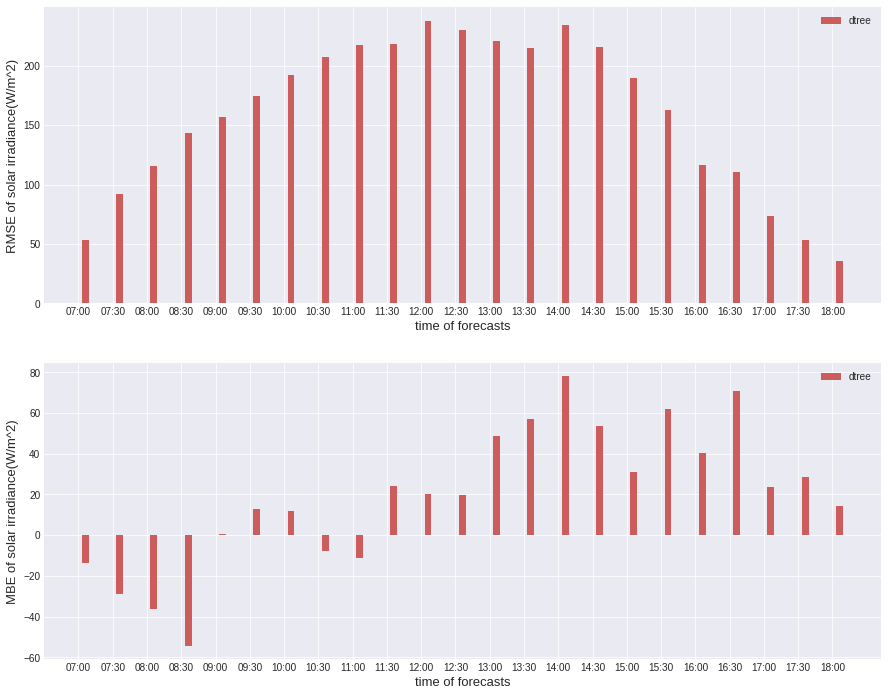

In [ ]:
dtree = pd.DataFrame()
dtree['measure'] = ybar_test
dtree['dtree'] = yhatbar_test
dtree['Datetime'] = date_test 
visualize(dtree, ['dtree'] , 'measure' ,show = False, save = False, visualize = True)

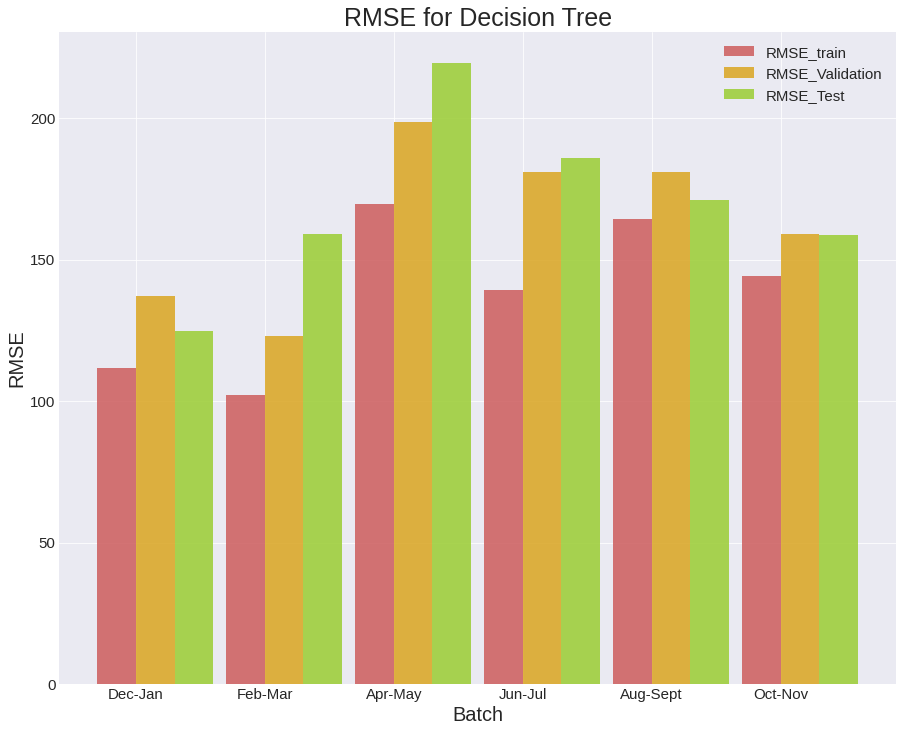

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,111.614912,137.297337,124.831689
1,Batch2,102.178830,123.136613,159.007573
2,Batch3,169.578461,198.525812,219.482465
3,Batch4,139.455027,181.008976,185.828851
4,Batch5,164.322346,181.044756,170.939436
5,Batch6,144.115598,159.191028,158.734077


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'Decision Tree')

### Random forest

In [ ]:
result_randforest = pd.DataFrame({"Max depth":[],"N_estimators":[],'Min_Sample_Split':[],'Max_Features':[],"rmse_validation":[],'rmse_train':[]})
result_randforest

,Max depth,N_estimators,Min_Sample_Split,Max_Features,rmse_validation,rmse_train


In [ ]:
rmse_list = []
dropped_features_list = []
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
r_2_list = []

max_depths = [3,4]
n_estimators = np.array([20,40])
min_sample_splits = [10,20]
max_features = ['auto','sqrt','log2']

hyperparameters = []


for max_depth in max_depths:
  for n_estimator in n_estimators:
    for min_sample_split in min_sample_splits:
      for max_feature in max_features:
        hyperparameters.append([max_depth,n_estimator,min_sample_split,max_feature])

for hyperparameter in hyperparameters:
  r_2_alpha = 0
  pred_list = np.empty(0)
  y_true_list = np.empty(0)
  pred_list_train = np.empty(0)
  y_true_list_train = np.empty(0)
  for i in range(len(batch_train_list)):

    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]

    randforest = RandomForestRegressor(max_depth=hyperparameter[0],n_estimators=hyperparameter[1],
                                       min_samples_split=hyperparameter[2],max_features=hyperparameter[3],random_state=0,n_jobs=-1)
    randforest.fit(batch_X_train,batch_y_train.values.ravel()) 
    y_pred_batch_randforest = randforest.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_randforest)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])

    y_pred_batch_randforest_train = randforest.predict(batch_X_train)
    pred_list_train = np.append(pred_list_train,y_pred_batch_randforest_train)
    y_true_list_train = np.append(y_true_list_train,batch_y_train.values.reshape(1,-1)[0])

  rmse = np.sqrt(mean_squared_error(y_true_list,pred_list))
  rmse_list.append(rmse)
  rmse_train = np.sqrt(mean_squared_error(y_true_list_train,pred_list_train))

  result_randforest = result_randforest.append(pd.DataFrame({"Max depth":[hyperparameter[0]],"N_estimators":[hyperparameter[1]],'Min_Sample_Split':[hyperparameter[2]],
                                                             'Max_Features':[hyperparameter[3]],"rmse_validation":[rmse],'rmse_train':[rmse_train]}))

In [ ]:
result_randforest.sort_values(by = "rmse_validation",ascending= True).head(5)

,Max depth,N_estimators,Min_Sample_Split,Max_Features,rmse_validation,rmse_train
0,4.0,40.0,20.0,log2,149.763715,142.370192
0,4.0,40.0,10.0,log2,149.972036,142.331265
0,4.0,20.0,20.0,log2,150.253529,142.922939
0,4.0,40.0,20.0,auto,150.433033,139.718638
0,4.0,40.0,10.0,auto,150.493809,139.635394


In [ ]:
result_randforest.sort_values(by = "rmse_validation",ascending= True).head(5)

,Max depth,N_estimators,Min_Sample_Split,Max_Features,rmse_validation,rmse_train
0,4.0,40.0,20.0,log2,149.763715,142.370192
0,4.0,40.0,10.0,log2,149.972036,142.331265
0,4.0,20.0,20.0,log2,150.253529,142.922939
0,4.0,40.0,20.0,auto,150.433033,139.718638
0,4.0,40.0,10.0,auto,150.493809,139.635394


In [ ]:
randforest = RandomForestRegressor(max_depth=13,n_estimators=80,min_samples_split = 20,max_features = 'log2',random_state=0)
pred_list = np.empty(0)
y_true_list = np.empty(0)
train_rmse_list = []
validation_rmse_list = []
feature_importance_list = []

feature_cols = ['I','RH','UV', 'WS', 'I^(d-1)(t+6)','I(t-1)', 'I(t-2)',
                'I(t-3)', 'I(t-4)', 'I(t-5)', 'I(t-6)', 'I(t-7)','sza(t+6)']
for i in range(len(batch_train_list)):
    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]

    
    randforest.fit(batch_X_train,batch_y_train.values.ravel()) 
    feature_importance_list.append(randforest.feature_importances_.tolist())
    y_pred_batch_randforest = randforest.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_randforest)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])
    y_pred_batch_randforest_train = randforest.predict(batch_X_train)

    rmse_batch_validation = np.sqrt(mean_squared_error(y_pred_batch_randforest,batch_y_validation))
    rmse_batch_train = np.sqrt(mean_squared_error(y_pred_batch_randforest_train,batch_y_train))
    
    validation_rmse_list.append(rmse_batch_validation)
    train_rmse_list.append(rmse_batch_train)
    

In [ ]:
feature_importance = np.mean(feature_importance_list,axis=0)
# feature_importance_list
pd.DataFrame({'Features':feature_cols,'Feature_Importance':feature_importance}).sort_values(by = 'Feature_Importance',ascending = True)


,Features,Feature_Importance
3,WS,0.024980
7,I(t-3),0.026996
6,I(t-2),0.029463
1,RH,0.029942
8,I(t-4),0.033336
2,UV,0.041645
9,I(t-5),0.045173
5,I(t-1),0.045908
10,I(t-6),0.055590
11,I(t-7),0.062394


In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0

train_rmse_list = []
validation_rmse_list = []
test_rmse_list = []

for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############
    ############ MODEL #######################
    randforest = RandomForestRegressor(max_depth=13,n_estimators=80,min_samples_split = 20,max_features = 'log2',random_state=0)
    randforest.fit(x_train,y_train)
    yhat_train = randforest.predict(x_train)
    yhat_val = randforest.predict(x_val)
    yhat_test = randforest.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    validation_rmse_list.append(rmse_val)

ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 79.8563149319804
batch1_validation : rmse = 111.21551807291083
batch1_test : rmse = 111.48626064957742

batch2_train : rmse = 79.23798678389481
batch2_validation : rmse = 113.00578530685536
batch2_test : rmse = 141.4702164233593

batch3_train : rmse = 126.87341178829705
batch3_validation : rmse = 187.79675243213487
batch3_test : rmse = 205.37066234990303

batch4_train : rmse = 110.87195443836771
batch4_validation : rmse = 162.58088866512165
batch4_test : rmse = 172.44537637501867

batch5_train : rmse = 127.88446196671084
batch5_validation : rmse = 169.16583969255512
batch5_test : rmse = 156.18408181716478

batch6_train : rmse = 108.69093752476009
batch6_validation : rmse = 142.447922710241
batch6_test : rmse = 129.99014926170213

average rmse of every batch in train = 107.48173234150573
average rmse of every batch in validation = 146.63900062856766
average rmse of every batch in test = 155.7242649269428


error summary

       randforest
MBE     15.195430
MAE    116.742385
RMSE   155.724265
NRMSE   15.572426



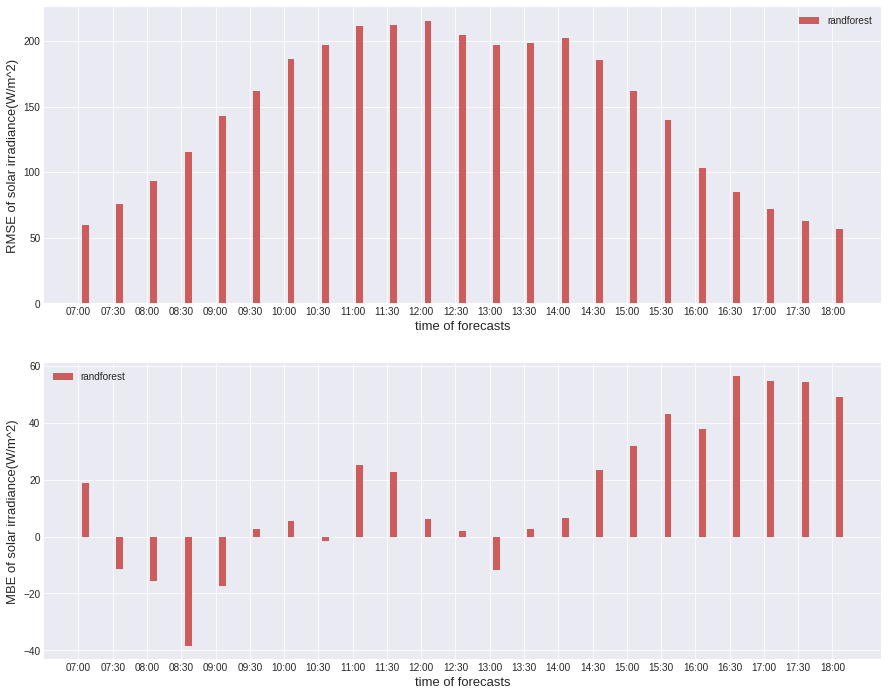

In [ ]:
randforest = pd.DataFrame()
randforest['measure'] = ybar_test
randforest['randforest'] = yhatbar_test
randforest['Datetime'] = date_test 
visualize(randforest, ['randforest'] , 'measure' ,show = False, save = False, visualize = True)

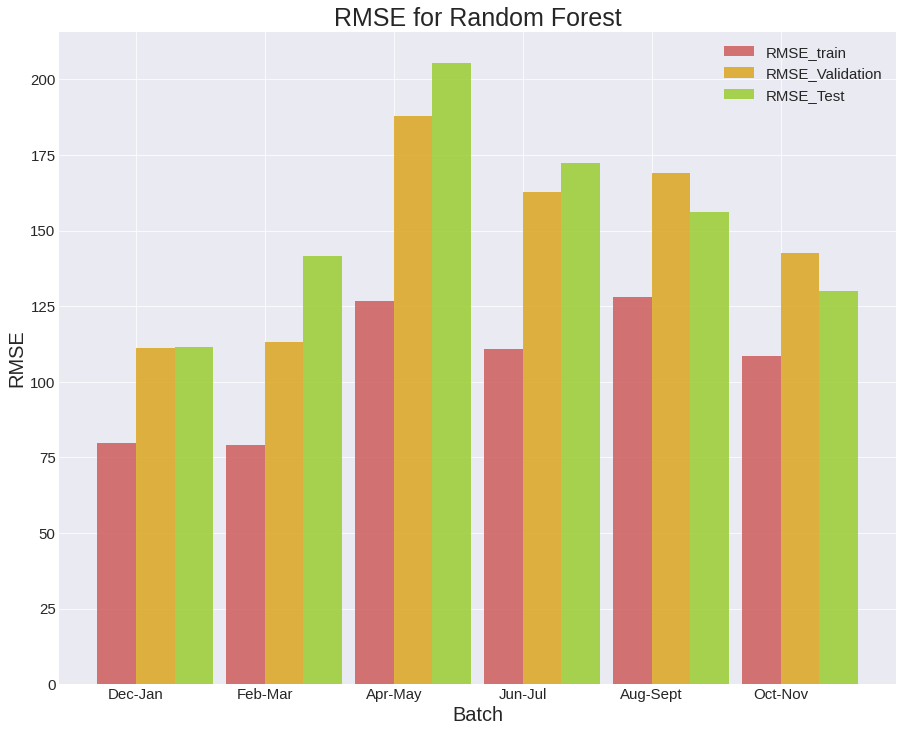

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,79.856315,111.215518,111.486261
1,Batch2,79.237987,113.005785,141.470216
2,Batch3,126.873412,187.796752,205.370662
3,Batch4,110.871954,162.580889,172.445376
4,Batch5,127.884462,169.165840,156.184082
5,Batch6,108.690938,142.447923,129.990149


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'Random Forest')

### Xgboost

In [ ]:
result_xgb = pd.DataFrame({"Max depth":[],"N_estimators":[],"learning rate":[],"Alpha":[],"Gamma":[],"rmse_validation":[],'rmse_train':[]})
result_xgb

,Max depth,N_estimators,learning rate,Alpha,Gamma,rmse_validation,rmse_train


In [ ]:
rmse_list = []
dropped_features_list = []
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]


max_depths = np.array([2,3,5])
n_estimators = np.array([5,10])
learning_rates = np.array([0.15,0.2])
alphas = [0.1,0.3]   #L1 Regularization
gammas = [0.1,0.3]

hyperparameters = []

for max_depth in max_depths:
  for n_estimator in n_estimators:
    for learning_rate in learning_rates:
      for alpha in alphas:
        for gamma in gammas:
          hyperparameters.append([max_depth,n_estimator,learning_rate,alpha,gamma])

for hyperparameter in hyperparameters:
  #r_2_alpha = 0
  pred_list = np.empty(0)
  y_true_list = np.empty(0)
  pred_list_train = np.empty(0)
  y_true_list_train = np.empty(0)
  for i in range(len(batch_train_list)):

    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]

    xgb_model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=hyperparameter[0],learning_rate=hyperparameter[2],
                                 n_estimators=hyperparameter[1],gamma=hyperparameter[4],alpha=hyperparameter[3],random_state=0,n_jobs=-1)
    xgb_model.fit(batch_X_train,batch_y_train.values.ravel()) 
    y_pred_batch_xgb = xgb_model.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_xgb)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])

    y_pred_batch_xgb_train = xgb_model.predict(batch_X_train)
    pred_list_train = np.append(pred_list_train,y_pred_batch_xgb_train)
    y_true_list_train = np.append(y_true_list_train,batch_y_train.values.reshape(1,-1)[0])

  rmse = np.sqrt(mean_squared_error(y_true_list,pred_list))
  rmse_list.append(rmse)
  result_xgb = result_xgb.append(pd.DataFrame({"Max depth":[hyperparameter[0]],"N_estimators":[hyperparameter[1]],"learning rate":[hyperparameter[2]],
                                               "Alpha":[hyperparameter[3]],"Gamma":[hyperparameter[4]],
                                               "rmse_validation":[np.sqrt(mean_squared_error(y_true_list,pred_list))],
                                               'rmse_train':[np.sqrt(mean_squared_error(y_true_list_train,pred_list_train))]}))

In [ ]:
result_xgb.sort_values(by = "rmse_validation",ascending= True).head(5) ##reg:squarederror

,Max depth,N_estimators,learning rate,Alpha,Gamma,rmse_validation,rmse_train
0,3.0,10.0,0.2,0.1,0.1,155.794882,147.194070
0,3.0,10.0,0.2,0.1,0.3,155.794882,147.194070
0,3.0,10.0,0.2,0.3,0.1,155.794882,147.194070
0,3.0,10.0,0.2,0.3,0.3,155.794882,147.194070
0,2.0,10.0,0.2,0.3,0.3,157.602990,156.193741


In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []


train_rmse_list = []
validation_rmse_list = []
test_rmse_list = []


n = 0
for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############
    ############ MODEL #######################
    xgboost = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3,learning_rate=0.2,
                                 n_estimators=20,gamma=0.1,alpha=0.1,random_state=0,n_jobs=-1)
    xgboost.fit(x_train,y_train)
    yhat_train = xgboost.predict(x_train)
    yhat_val = xgboost.predict(x_val)
    yhat_test = xgboost.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)

    train_rmse_list.append(rmse_train)
    validation_rmse_list.append(rmse_val)
    test_rmse_list.append(rmse_test)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 98.95102017971367
batch1_validation : rmse = 116.95379832210341
batch1_test : rmse = 114.33712398445651

batch2_train : rmse = 94.92743462745199
batch2_validation : rmse = 115.61380857987493
batch2_test : rmse = 145.81858355210937

batch3_train : rmse = 154.55135843705114
batch3_validation : rmse = 193.51182884667048
batch3_test : rmse = 205.4598669634801

batch4_train : rmse = 129.84835151198016
batch4_validation : rmse = 166.74602652441334
batch4_test : rmse = 176.23260066530187

batch5_train : rmse = 153.55500245430085
batch5_validation : rmse = 165.86936373560627
batch5_test : rmse = 161.23689040542277

batch6_train : rmse = 128.99704172431748
batch6_validation : rmse = 141.43623427238654
batch6_test : rmse = 135.88809264258876

average rmse of every batch in train = 129.05017687146085
average rmse of every batch in validation = 149.6512711645598
average rmse of every batch in test = 158.87625917651252


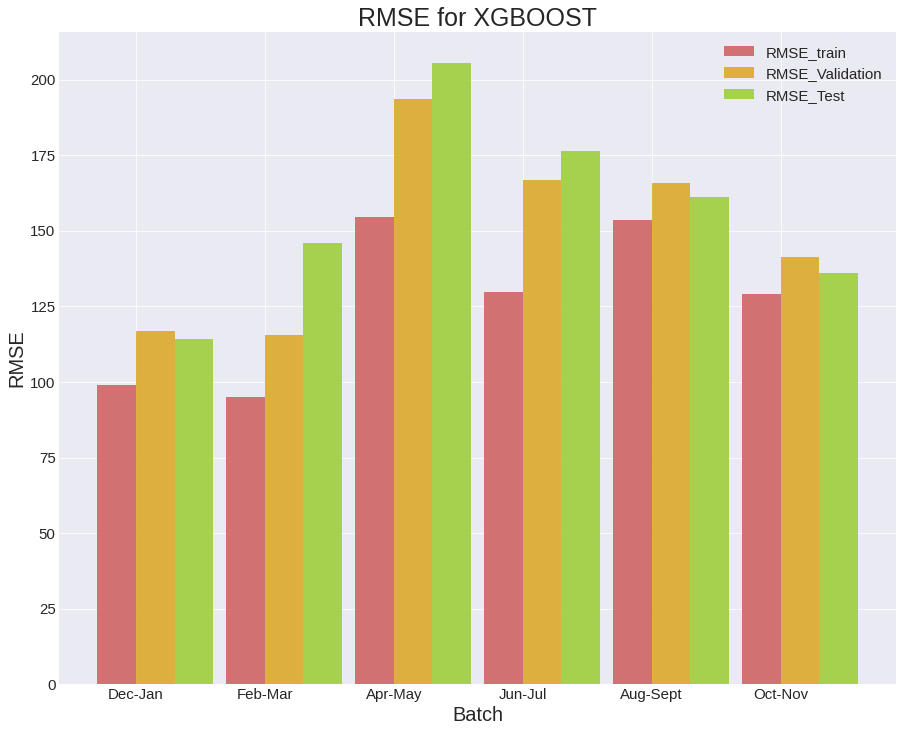

,batch,rmse_train,rmse_validation,rmse_test
0,Batch1,98.951020,116.953798,114.337124
1,Batch2,94.927435,115.613809,145.818584
2,Batch3,154.551358,193.511829,205.459867
3,Batch4,129.848352,166.746027,176.232601
4,Batch5,153.555002,165.869364,161.236890
5,Batch6,128.997042,141.436234,135.888093


In [ ]:
plot_train_validation(train_rmse_list,validation_rmse_list,test_rmse_list,'XGBOOST')

error summary

          xgboost
MBE      6.651157
MAE    115.957179
RMSE   158.876259
NRMSE   15.887626



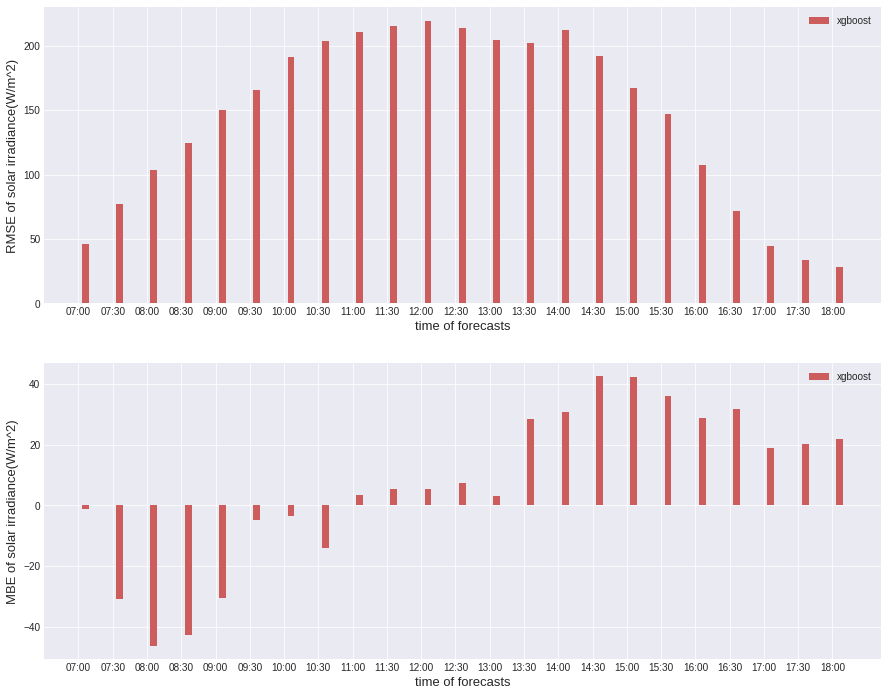

In [ ]:
xgboost = pd.DataFrame()
xgboost['measure'] = ybar_test
xgboost['xgboost'] = yhatbar_test
xgboost['Datetime'] = date_test 
visualize(xgboost, ['xgboost'] , 'measure' ,show = False, save = False, visualize = True)

# Visualize Validation Error

### Linear Regression Validation Predictions

In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0

train_rmse_list = []
test_rmse_list = []
validation_rmse_list = []

feature_cols = ['I','RH','UV', 'I^(d-1)(t+6)', 'I(t-4)', 'I(t-7)','sza(t+6)']

for idx,(batch_train,batch_val,batch_test) in enumerate(zip(batch_train_list,batch_validation_list,batch_test_list)):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############

    ############ MODEL #######################
    lin_reg = LinearRegression()
    lin_reg.fit(x_train,y_train)
    yhat_train = lin_reg.predict(x_train)
    yhat_val = lin_reg.predict(x_val)
    yhat_test = lin_reg.predict(x_test)
    
    yhat_val[yhat_val<0]=0
    yhat_test[yhat_test<0]=0
    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    validation_rmse_list.append(rmse_val)
    print(f'batch{idx+1}_train : rmse = {rmse_train}')
    print(f'batch{idx+1}_validation : rmse = {rmse_val}')
    print(f'batch{idx+1}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

batch1_train : rmse = 120.68314141789247
batch1_validation : rmse = 124.96481567045082
batch1_test : rmse = 119.57703877907866

batch2_train : rmse = 113.37568772828105
batch2_validation : rmse = 127.70760622285967
batch2_test : rmse = 150.6904869641206

batch3_train : rmse = 180.86992437651318
batch3_validation : rmse = 193.15227237159397
batch3_test : rmse = 214.42974953668417

batch4_train : rmse = 147.85397082618857
batch4_validation : rmse = 163.0317064023638
batch4_test : rmse = 176.57427153433773

batch5_train : rmse = 173.43432449319639
batch5_validation : rmse = 171.2213711391146
batch5_test : rmse = 158.28760122058026

batch6_train : rmse = 156.2463639665472
batch6_validation : rmse = 147.82340119983542
batch6_test : rmse = 135.23533301570862

average rmse of every batch in train = 150.9399055575839
average rmse of every batch in validation = 153.89228064172679
average rmse of every batch in test = 162.2984584656066


In [ ]:
df_visualize = pd.DataFrame({'Datetime':date_val,'I(t+6)':ybar_val,'Lin_Reg_Predictions':yhatbar_val})

In [ ]:
feature_cols = ['I','RH','UV', 'I^(d-1)(t+6)', 'I(t-4)', 'I(t-7)','sza(t+6)']
ridge = Ridge(alpha = 19.491)                
pred_list = np.empty(0)
y_true_list = np.empty(0)
date_column = []
for i in range(len(batch_train_list)):
  batch_X_train = batch_train_list[i][feature_cols]
  batch_y_train = batch_train_list[i][target]
  batch_X_validation =  batch_validation_list[i][feature_cols]
  batch_y_validation =  batch_validation_list[i][target]
  scaler = StandardScaler()
  batch_X_train = scaler.fit_transform(batch_X_train)
  batch_X_validation = scaler.transform(batch_X_validation)
  ridge.fit(batch_X_train,batch_y_train)
  y_pred_batch_ridge = ridge.predict(batch_X_validation)
  pred_list = np.append(pred_list ,y_pred_batch_ridge)
  pred_list[pred_list<0]=0
  y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])
  date_column = date_column + batch_y_validation.reset_index()['DATETIME'].tolist()
df_visualize['Ridge_Predictions'] = pred_list

In [ ]:
lasso = Lasso(alpha = 1.2)
pred_list = np.empty(0)
y_true_list = np.empty(0)
for i in range(len(batch_train_list)):
  batch_X_train = batch_train_list[i][feature_cols]
  batch_y_train = batch_train_list[i][target]
  batch_X_validation =  batch_validation_list[i][feature_cols]
  batch_y_validation =  batch_validation_list[i][target]
  scaler = StandardScaler()
  batch_X_train = scaler.fit_transform(batch_X_train)
  batch_X_validation = scaler.transform(batch_X_validation)
  lasso.fit(batch_X_train,batch_y_train)
  y_pred_batch_lasso = lasso.predict(batch_X_validation)
  pred_list = np.append(pred_list ,y_pred_batch_lasso)
  pred_list[pred_list<0]=0
  y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])

df_visualize['Lasso_Predictions'] = pred_list


In [ ]:
elastic = ElasticNet(alpha=1.2,l1_ratio=1)
pred_list = np.empty(0)
y_true_list = np.empty(0)
for i in range(len(batch_train_list)):
  batch_X_train = batch_train_list[i][feature_cols]
  batch_y_train = batch_train_list[i][target]
  batch_X_validation =  batch_validation_list[i][feature_cols]
  batch_y_validation =  batch_validation_list[i][target]
  scaler = StandardScaler()
  batch_X_train = scaler.fit_transform(batch_X_train)
  batch_X_validation = scaler.transform(batch_X_validation)
  elastic.fit(batch_X_train,batch_y_train) 
  y_pred_batch_elastic = elastic.predict(batch_X_validation)
  pred_list = np.append(pred_list ,y_pred_batch_elastic)
  pred_list[pred_list<0]=0
  y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])

df_visualize['Elastic_Predictions'] = pred_list

In [ ]:
dtree = DecisionTreeRegressor(max_depth=4,random_state=0)
pred_list = np.empty(0)
y_true_list = np.empty(0)
for i in range(len(batch_train_list)):
    batch_X_train = batch_train_list[i][feature_cols]
    batch_y_train = batch_train_list[i][target]
    batch_X_validation =  batch_validation_list[i][feature_cols]
    batch_y_validation =  batch_validation_list[i][target]
    
    dtree.fit(batch_X_train,batch_y_train) 
    y_pred_batch_dtree = dtree.predict(batch_X_validation)

    pred_list = np.append(pred_list ,y_pred_batch_dtree)
    y_true_list = np.append(y_true_list,batch_y_validation.values.reshape(1,-1)[0])
df_visualize['Dtree_Predictions'] = pred_list

In [ ]:
df_visualize

,Datetime,I(t+6),Lin_Reg_Predictions,Ridge_Predictions,Lasso_Predictions,Elastic_Predictions,Dtree_Predictions
0,2018-12-01 07:00:00,82.800,15.258816,20.150360,18.747914,18.747914,15.880588
1,2018-12-01 07:30:00,142.233,89.330589,93.720312,92.536141,92.536141,49.867654
2,2018-12-01 08:00:00,264.300,137.534346,141.474487,140.090425,140.090425,176.957872
3,2018-12-01 08:30:00,293.000,229.931190,233.474175,232.393719,232.393719,176.957872
4,2018-12-01 09:00:00,406.400,267.747282,270.358247,269.286732,269.286732,284.867200
...,...,...,...,...,...,...,...
3335,2018-11-15 16:00:00,200.000,248.171919,244.477981,244.589160,244.589160,264.060992
3336,2018-11-15 16:30:00,104.300,214.727305,207.912261,201.750473,201.750473,125.403834
3337,2018-11-15 17:00:00,52.933,173.992674,167.393220,157.111734,157.111734,71.507653
3338,2018-11-15 17:30:00,9.100,61.216155,59.139110,50.918270,50.918270,71.507653


In [ ]:
feature_cols = ['I','RH','UV', 'WS', 'I^(d-1)(t+6)','I(t-1)', 'I(t-2)',
                'I(t-3)', 'I(t-4)', 'I(t-5)', 'I(t-6)', 'I(t-7)','sza(t+6)']


batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0

train_rmse_list = []
validation_rmse_list = []
test_rmse_list = []

for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############
    ############ MODEL #######################
    randforest = RandomForestRegressor(max_depth=6,n_estimators=80,min_samples_split = 20,max_features = 'log2',random_state=0)
    randforest.fit(x_train,y_train)
    yhat_train = randforest.predict(x_train)
    yhat_val = randforest.predict(x_val)
    yhat_test = randforest.predict(x_test)

    print(x_test.shape)
    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
    train_rmse_list.append(rmse_train)
    test_rmse_list.append(rmse_test)
    validation_rmse_list.append(rmse_val)

ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

df_visualize['RForest_Predictions'] = yhatbar_val

(736, 13)
batch1_train : rmse = 97.97684230687275
batch1_validation : rmse = 112.62955140369175
batch1_test : rmse = 108.18480578876148

(667, 13)
batch2_train : rmse = 98.33726432775215
batch2_validation : rmse = 116.73797608870186
batch2_test : rmse = 146.29766301260017

(713, 13)
batch3_train : rmse = 157.51259901099274
batch3_validation : rmse = 190.14939892893275
batch3_test : rmse = 207.9607533716432

(345, 13)
batch4_train : rmse = 133.62924496409767
batch4_validation : rmse = 168.36854602010453
batch4_test : rmse = 174.47472933967376

(649, 13)
batch5_train : rmse = 154.21131198023718
batch5_validation : rmse = 169.43479856819357
batch5_test : rmse = 154.92288506165332

(441, 13)
batch6_train : rmse = 131.68830030794803
batch6_validation : rmse = 144.9994414033683
batch6_test : rmse = 132.23639986636772

average rmse of every batch in train = 131.14892761944566
average rmse of every batch in validation = 149.40255980685424
average rmse of every batch in test = 156.9887408301855

In [ ]:
batch_validation_list = [batch1_validation,batch2_validation,batch3_validation,batch4_validation,batch5_validation,batch6_validation]
batch_train_list = [batch1_train,batch2_train,batch3_train,batch4_train,batch5_train,batch6_train]
batch_test_list = [batch1_test,batch2_test,batch3_test,batch4_test,batch5_test,batch6_test]

ybar_train = []
ybar_val = []
ybar_test = []

yhatbar_train = []
yhatbar_val = []
yhatbar_test = []

date_train = []
date_val = []
date_test = []
n = 0
for batch_train,batch_val,batch_test in zip(batch_train_list,batch_validation_list,batch_test_list):
    n += 1
    y_train = batch_train['I(t+6)'].values
    y_val = batch_val['I(t+6)'].values
    y_test = batch_test['I(t+6)'].values

    ############ FEATURE FOR MODEL #############
    x_train = batch_train[feature_cols].values
    x_val = batch_val[feature_cols].values
    x_test = batch_test[feature_cols].values
    ############ FEATURE FOR MODEL #############
    ############ MODEL #######################
    xgboost = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3,learning_rate=0.2,
                                 n_estimators=20,gamma=0.1,alpha=0.1,random_state=0,n_jobs=-1)
    xgboost.fit(x_train,y_train)
    yhat_train = xgboost.predict(x_train)
    yhat_val = xgboost.predict(x_val)
    yhat_test = xgboost.predict(x_test)

    ############ MODEL #######################
    
    rmse_train = (mean_squared_error(y_train,yhat_train))**(1/2)
    rmse_val = (mean_squared_error(y_val,yhat_val))**(1/2)
    rmse_test = (mean_squared_error(y_test,yhat_test))**(1/2)
    
    ybar_train.append(y_train)
    ybar_val.append(y_val)
    ybar_test.append(y_test)
    
    yhatbar_train.append(yhat_train)
    yhatbar_val.append(yhat_val)
    yhatbar_test.append(yhat_test)
    
    date_train.append(batch_train.index)
    date_val.append(batch_val.index)
    date_test.append(batch_test.index)

    print(f'batch{n}_train : rmse = {rmse_train}')
    print(f'batch{n}_validation : rmse = {rmse_val}')
    print(f'batch{n}_test : rmse = {rmse_test}')
    print('')
    
ybar_train = np.concatenate(ybar_train)
ybar_val = np.concatenate(ybar_val)
ybar_test = np.concatenate(ybar_test)

yhatbar_train = np.concatenate(yhatbar_train)
yhatbar_val = np.concatenate(yhatbar_val)
yhatbar_test = np.concatenate(yhatbar_test)

date_train = np.concatenate(date_train)
date_val = np.concatenate(date_val)
date_test = np.concatenate(date_test)

#convert to forecast time
date_train = date_train + np.timedelta64(3, 'h')
date_val = date_val + np.timedelta64(3, 'h')
date_test = date_test + np.timedelta64(3, 'h')

print(f'average rmse of every batch in train = {(mean_squared_error(ybar_train,yhatbar_train))**(1/2)}')
print(f'average rmse of every batch in validation = {(mean_squared_error(ybar_val,yhatbar_val))**(1/2)}')
print(f'average rmse of every batch in test = {(mean_squared_error(ybar_test,yhatbar_test))**(1/2)}')

df_visualize['XGBoost_Predictions'] = yhatbar_val

batch1_train : rmse = 98.95102017971367
batch1_validation : rmse = 116.95379832210341
batch1_test : rmse = 114.33712398445651

batch2_train : rmse = 94.92743462745199
batch2_validation : rmse = 115.61380857987493
batch2_test : rmse = 145.81858355210937

batch3_train : rmse = 154.55135843705114
batch3_validation : rmse = 193.51182884667048
batch3_test : rmse = 205.4598669634801

batch4_train : rmse = 129.84835151198016
batch4_validation : rmse = 166.74602652441334
batch4_test : rmse = 176.23260066530187

batch5_train : rmse = 153.55500245430085
batch5_validation : rmse = 165.86936373560627
batch5_test : rmse = 161.23689040542277

batch6_train : rmse = 128.99704172431748
batch6_validation : rmse = 141.43623427238654
batch6_test : rmse = 135.88809264258876

average rmse of every batch in train = 129.05017687146085
average rmse of every batch in validation = 149.6512711645598
average rmse of every batch in test = 158.87625917651252


In [ ]:
df_visualize.head(5)

,Datetime,I(t+6),Lin_Reg_Predictions,Ridge_Predictions,Lasso_Predictions,Elastic_Predictions,Dtree_Predictions,RForest_Predictions,XGBoost_Predictions
0,2018-12-01 07:00:00,82.800,15.258816,20.150360,18.747914,18.747914,15.880588,74.550593,49.653385
1,2018-12-01 07:30:00,142.233,89.330589,93.720312,92.536141,92.536141,49.867654,120.747647,98.356133
2,2018-12-01 08:00:00,264.300,137.534346,141.474487,140.090425,140.090425,176.957872,172.555751,131.698532
3,2018-12-01 08:30:00,293.000,229.931190,233.474175,232.393719,232.393719,176.957872,255.227321,211.794708
4,2018-12-01 09:00:00,406.400,267.747282,270.358247,269.286732,269.286732,284.867200,361.277349,321.418396


error summary

       RForest_Predictions  XGBoost_Predictions  Lasso_Predictions
MBE               9.172834            -4.645701          18.190905
MAE             113.567430           109.670694         114.655780
RMSE            149.402560           149.651271         153.030866
NRMSE            14.940256            14.965127          15.303087



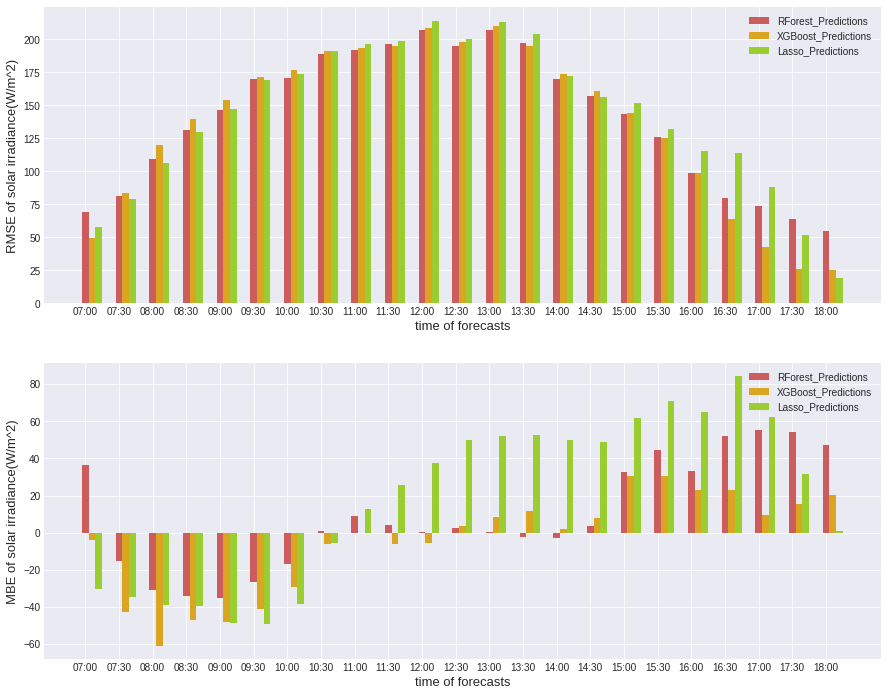

In [ ]:
visualize(df_visualize,['RForest_Predictions','XGBoost_Predictions','Lasso_Predictions'],measure_col='I(t+6)')

# Predicting Test set

In [ ]:
test_X = test_batch.loc[:,test_batch.columns != 'I(t+6)']
test_y = test_batch.loc[:,test_batch.columns == 'I(t+6)']

,I(t+6)
DATETIME,
2018-01-01 04:00:00,25.200
2018-01-01 04:30:00,117.240
2018-01-01 05:00:00,250.200
2018-01-01 05:30:00,352.800
2018-01-01 06:00:00,450.100
...,...
2018-12-31 13:00:00,219.400
2018-12-31 13:30:00,92.000
2018-12-31 14:00:00,63.800
